# Estimating Rainy Lake Inflows 1971-2010

* <a href=#section01>Direct Estimate using the Balance Equation</a>
* <a href=#section02>Estimating Rainy Lake Inflows with a Kalman Filter</a>
* <a href=#section03>Comparing Inflows in 1971-1999 to 2000-2010</a>
* <a href=#section04>Correlation of Precipitation with Lake Inflow</a>

### Initialization

Initilization of the graphics system and computational modules used in this IPython notebook.

In [1]:
# Display graphics inline with the notebook
%matplotlib inline

# Standard Python modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import os
import datetime

# Module to enhance matplotlib plotting
import seaborn
seaborn.set()

# Modules to display images and data tables
from IPython.display import Image
from IPython.core.display import display

# Data Directory
dir = './data/'

# Styles
from IPython.core.display import HTML
HTML(open("styles/custom.css", "r").read())

## <a name=section01></a>Direct Estimate using the Balance Equation

A crude estimate of inflows can be found starting with the balance equation

$$A_{RL}\frac{dH_{RL}}{dt} = I_{RL}(t) - O_{RL}(t)$$

where the subscript RL refers to Rainy Lake, and $A$, $H$, $I$, and $O$ refer to area, lake level, inflow, and outflow, respectively. Discretizing in time

$$\frac{A_{RL}}{\Delta t}\left(H_{RL}(k+1)-H_{RL}(k)\right) = I_{RL}(k) - O_{RL}(k)$$

Since the sole output flow from Rainy Lake is through Rainy River, we can solve for inflow

$$I_{RL}(k) = \frac{A_{RL}}{\Delta t}\left(H_{RL}(k+1)-H_{RL}(k)\right) + O_{RL}(k)$$

The estimation method is sensitive to small errors in level measurement and therefore provides an estimate of the inflow plagued by excessive noise.

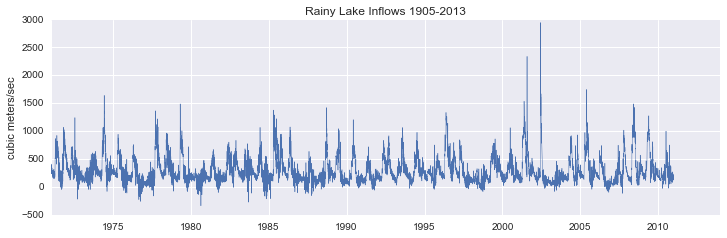

In [2]:
# Load Rainy River Flow and Rainy Lake Level data
RR = pd.read_pickle(dir+'RR.pkl')
RL = pd.read_pickle(dir+'RL.pkl')

# Rainy Lake area (sq. meters)
A = 95700*10000

inflow = A*(RL.shift(-1) - RL)/(24*3600) + RR

plt.figure(figsize=(12,3.5))
inflow['1971':].plot(linewidth=0.5)
plt.title('Rainy Lake Inflows {0}-{1}'.format(
    inflow.index.min().strftime('%Y'),
    inflow.index.max().strftime('%Y')))
plt.ylabel('cubic meters/sec');

Plotting the estimated inflow for a typical year demonstrates the noisy characteristics of this estimate.

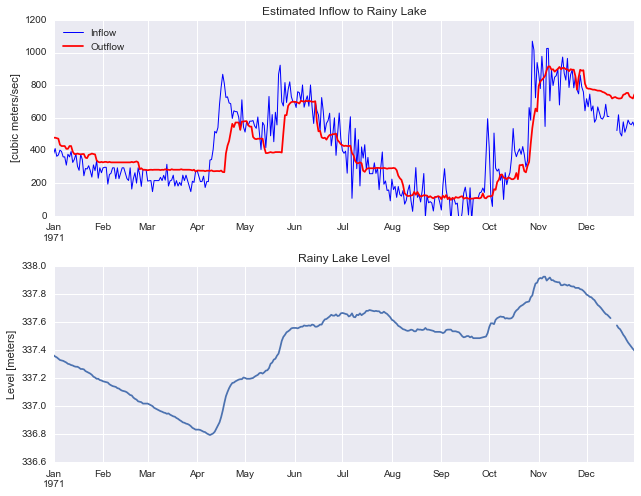

In [3]:
yr = '1971'

plt.figure(figsize=(9,7))
plt.subplot(2,1,1)
plt.hold(True)
inflow[yr].plot(color='b',linewidth=1)
RR[yr].plot(color='r')
plt.hold(False)

ax = plt.axis()
plt.ylim([0,ax[3]])
plt.ylabel('[cubic meters/sec]')
plt.title('Estimated Inflow to Rainy Lake')
plt.legend(['Inflow','Outflow'],loc='upper left')

plt.subplot(2,1,2)
RL[yr].plot()
plt.ylabel('Level [meters]')
plt.title('Rainy Lake Level')
plt.tight_layout()

## <a name=section02></a>Estimating Rainy Lake Inflows with a Kalman Filter

For this first model we assume the inflows and outflows to Rainy Lake are exogenous disturbances driven by zero mean white noise. Later we can consider models that incorporate features such as mean seasonal inflows, the dependence of outflow on lake level, and the an additional state variable representing the International Falls Dam. The purpose of this first model is to simply test the idea that a filtering and estimation techniques can provide better knowledge of the ungauged inflows to Rainy Lake.

The model is written

$$\underbrace{\left[\begin{array}{c} H_{RL}(k+1) \\ I_{RL}(k+1) \\ O_{RL}(k+1) \end{array}\right]}_{x(k+1)} = \underbrace{\left[ \begin{array}{ccc} 1 & \frac{\Delta t}{A_{RL}} & -\frac{\Delta t}{A_{RL}} \\0 & 1 & 0\\0 & 0 &  1\end{array}\right]}_{A} \underbrace{\left[\begin{array}{c} H_{RL}(k) \\ I_{RL}(k) \\ O_{RL}(k) \end{array}\right]}_{x(k)} + \underbrace{\left[ \begin{array}{c} 0 \\ w_{I}(k) \\ w_{O}(k)\end{array}\right]}_{w(k)}$$

where $H$, $I$, $O$ are lake level, inflow, and outflow, respectively. The signals $w_I(k)$, and $w_O(k)$ are zero-mean independent and identically distributed random increments to changing lake inflow and outflows. The vector $w(k)$ is assumed to be distributed as multivariate Normal distribution with zero mean and a covariance $Q$.

The measurement model is written

$$\underbrace{\left[\begin{array}{c} y_H(k) \\ y_O(k) \end{array}\right]}_{y(k)} = \underbrace{\left[\begin{array}{ccc} 1 & 0 & 0 \\ 0 & 0 & 1 \end{array}\right]}_{C} \underbrace{\left[\begin{array}{c} H_{RL}(k) \\ I_{RL}(k) \\ O_{RL}(k) \end{array}\right]}_{x(k)} +  \underbrace{\left[\begin{array}{c}  v_{H}(k) \\ v_{O}(k) \end{array}\right]}_{v(k)} $$

where the measurement noise vector $v(k)$ is an i.i.d. random variate with zero mean and a covariance $R$.

A Kalman filter provides a two step method for estimate values of the state vector $x(k)$. The the estimate of $x(k)$ using all information available up to time $k-1$ is the prediction step given by 

$$\hat{x}(k|k-1) = A \hat{x}(k-1|k-1)$$

with covariance

$$\hat{P}(k|k-1) = A \hat{P}(k-1|k-1) A^T + Q$$

In the measurement update step, an innovation is the difference between the actual measurement at time $k$ versus the predicted measurement

$$e(k) = y(k) - C x(k|k-1)$$

with covariance

$$S(k) = C\hat{P}(k|k-1)C^T + R$$

The Kalman filter gain is given by

$$K(k) = \hat{P}(k|k-1)C^TS^{-1}(k)$$

which is used to compute the updated state estimate

$$\hat{x}(k|k) = \hat{x}(x|k-1) + K(k)e(k)$$

and 

$$\hat{P}(k|k) = \hat{P}(k|k-1) - K(k)S(k)K^T(k)$$

This is implemented in the following cells for the purpose of estimating inflow to Rainy Lake from historical data of lake levels and outflows.

In [4]:
areaRL = float(97500*10000)
dt = float(24*3600)

A = np.array([[1.0, dt/areaRL, -dt/areaRL],
     [0.0, 1.0, 0.0],
     [0.0, 0.0, 1.0]])

C = np.array([[1.0, 0.0, 0.0],
              [0.0, 0.0, 1.0]])

# Covariance of state inputs
Q = np.array([[0.0, 0.0, 0.0],
              [0.0, 10000.0, 0.0],
              [0.0, 0.0, 10000.0]])

# Measurement covariance
R = np.array([[0.0001, 0],[0.0, 1000.0]])

In [5]:
# Load Rainy Lake Level and Rainy River Flow data

yrA = '1971'
yrB = '2010'

y = pd.concat([pd.read_pickle(dir+'RL.pkl')[yrA:yrB],
               pd.read_pickle(dir+'RR.pkl')[yrA:yrB]],axis=1)
y.columns = ['H','O']

y = y.interpolate()

In [6]:
# DataFrame to store results
x = pd.DataFrame(index = y.index,columns=('H','I','O'))
e = pd.DataFrame(index = y.index,columns=('H','O'))

# Initial values for x and P

x.ix[0] = np.array([y.ix[0]['H'], y.ix[0]['O'], y.ix[0]['O']])
e.ix[0] = np.array([0,0])
P = np.array([[0.001, 0.0, 0.0], [0.0, 100.0, 0.0], [0.0, 0.0, 100.0]])

# Kalman Filter
for k in range(1,len(y.index)):
    # Prediction
    xpred = np.dot(A,x.ix[k-1])
    Ppred = np.dot(np.dot(A,P),np.transpose(A)) + Q
    # Measurement
    ymeas = np.array([y.ix[k]['H'],y.ix[k]['O']])
    # Update
    e.ix[k] = ymeas - np.dot(C,xpred)
    S = np.dot(np.dot(C,Ppred),np.transpose(C)) + R
    K = np.dot(np.dot(Ppred,np.transpose(C)),np.linalg.inv(S))
    x.ix[k] = xpred + np.dot(K,e.ix[k])
    P = Ppred - np.dot(np.dot(K,S),np.transpose(K))
    
# Pickle Rainy Lake Inflows for use in other notebooks
x['I'].to_pickle('./data/RLInflows.pkl')
x['H'].to_pickle('./data/RLLevels.pkl')
x['O'].to_pickle('./data/RLOutflows.pkl')

x.to_csv('./data/RLEstimates.csv')

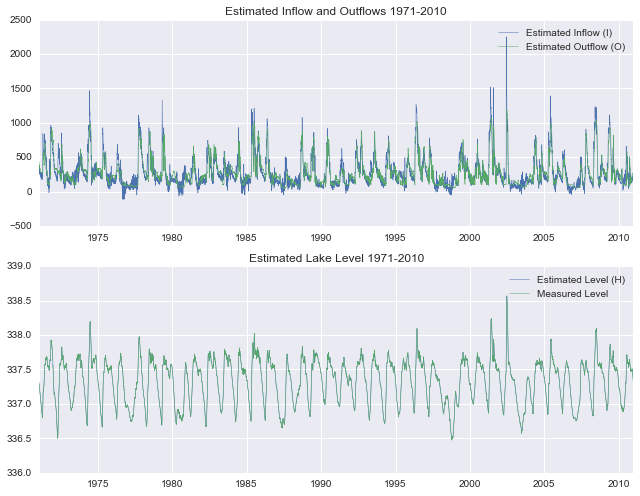

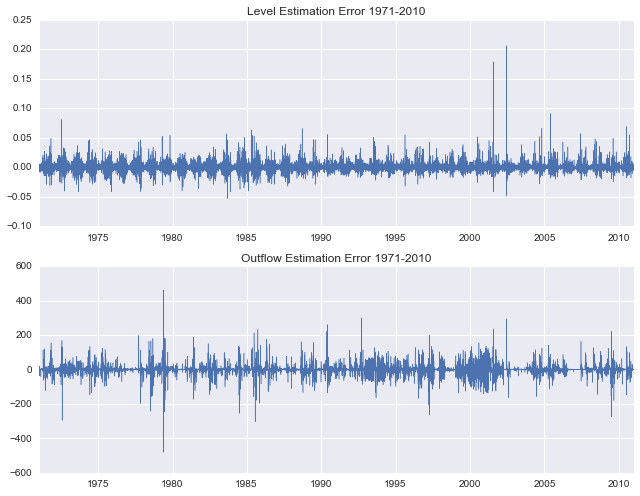

In [7]:
plt.figure(figsize=(9,7))

plt.subplot(2,1,1)
plt.hold(True)
x['I'].plot(linewidth=0.5)
x['O'].plot(linewidth=0.5)
plt.hold(False)
plt.title('Estimated Inflow and Outflows ' + yrA + '-' + yrB)
plt.legend(['Estimated Inflow (I)','Estimated Outflow (O)'])

plt.subplot(2,1,2)
plt.hold(True)
x['H'].plot(linewidth=0.5)
RL[yrA:yrB].plot(linewidth=0.5)
plt.hold(False)
plt.title('Estimated Lake Level ' + yrA + '-' + yrB)
plt.legend(['Estimated Level (H)','Measured Level'])

plt.tight_layout()
    
plt.figure(figsize=(9,7))

plt.subplot(2,1,1)
e['H'].plot(linewidth=0.5)
plt.title('Level Estimation Error ' + yrA + '-' + yrB)

plt.subplot(2,1,2)
e['O'].plot(linewidth=0.5)
plt.title('Outflow Estimation Error ' + yrA + '-' + yrB)

plt.tight_layout()

## <a name=section03></a>Comparing Inflows in 1971-1999 to 2000-2010

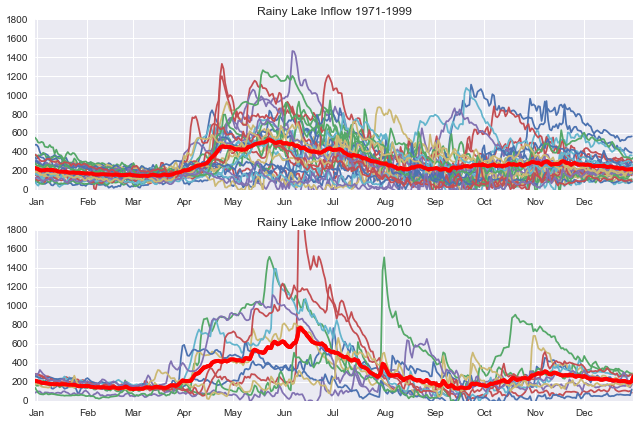

In [8]:
# Shift to a common year
I = pd.DataFrame([])
for yr,r in x['I'].groupby(x.index.year):
    shift = datetime.datetime(2014,1,1) - datetime.datetime(yr,1,1)
    r = r.tshift(shift.days)
    r.name = yr
    I = pd.concat([I,r],axis=1)
    
# Plot
plt.figure(figsize=(9,6))
plt.subplot(2,1,1)
idx = range(1971,2000)
I[idx].mean(axis=1).plot(color='r',linewidth=4)
plt.hold(True)
I[idx].plot(ax=plt.gca(),legend=False)
I[idx].mean(axis=1).plot(color='r',linewidth=4)
plt.ylim(0,1800)
plt.title('Rainy Lake Inflow 1971-1999')
plt.hold(False)

import matplotlib.dates as mdates

plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))

# Plot
plt.subplot(2,1,2)
idx = range(2000,2011)
I[idx].mean(axis=1).plot(color='r',linewidth=4)
plt.hold(True)
I[idx].plot(ax=plt.gca(),legend=False)
I[idx].mean(axis=1).plot(color='r',linewidth=4)
plt.ylim(0,1800)
plt.title('Rainy Lake Inflow 2000-2010')
plt.hold(False)

import matplotlib.dates as mdates

plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))

plt.tight_layout()

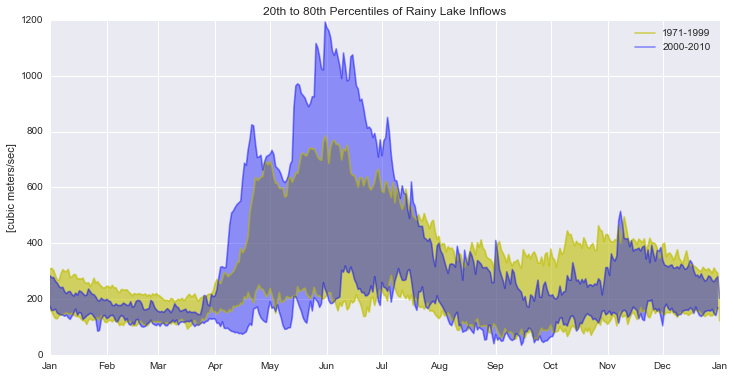

In [9]:
plt.figure(figsize=(12,6))
plt.hold(True)

q_hi = 80
q_lo = 20

idx = range(1971,2000)
plt.plot(I[idx].index,
         np.percentile(I[idx],q=q_hi,axis=1),
         color='y',alpha=0.6)
a, = plt.plot(I[idx].index,
             np.percentile(I[idx],q=q_lo,axis=1),
             color='y',alpha=0.6,label='1971-1999')
plt.fill_between(I[idx].index,
                 np.percentile(I[idx],q=q_hi,axis=1).tolist(),
                 np.percentile(I[idx],q=q_lo,axis=1).tolist(),
                 color='y',alpha=0.6)

idx = range(2000,2011)
plt.plot(I[idx].index,
         np.percentile(I[idx],q=q_hi,axis=1),
         color='b',alpha=0.4)
b, = plt.plot(I[idx].index,
             np.percentile(I[idx],q=q_lo,axis=1),
             color='b',alpha=0.4,label='2000-2010')

plt.fill_between(I[idx].index,
                 np.percentile(I[idx],q=q_hi,axis=1).tolist(),
                 np.percentile(I[idx],q=q_lo,axis=1).tolist(),
                 color='b',alpha=0.4)

plt.hold(False)
plt.title('{:d}th to {:d}th Percentiles of Rainy Lake Inflows'.format(q_lo,q_hi))
plt.ylabel('[cubic meters/sec]')
plt.legend(handles=[a,b])

import matplotlib.dates as mdates

plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))

fname = './images/RainyLakeInflows.png'

plt.savefig(fname)
!convert $fname -trim $fname
!convert $fname -transparent white $fname

In [10]:
%%capture capt
%run -i Predicted_Effect_of_Rule_Curve_Changes_on_Rainy_River_Flows.ipynb

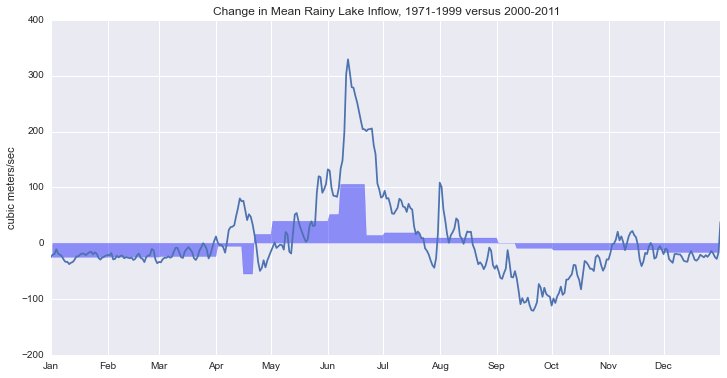

In [11]:
areaNL = 25973 * 10000   

dNL1970 = 0.5*(NL1970['LRC']+NL1970['URC']).diff()
dNL2000 = 0.5*(NL2000['LRC']+NL2000['URC']).diff()

qNL1970 = -areaNL*dNL1970/(24*3600)
qNL2000 = -areaNL*dNL2000/(24*3600)

dqNL = qNL2000 - qNL1970

plt.figure(figsize=(12,6))

plt.hold(True)
(I[range(2000,2011)].mean(axis=1)-I[range(1971,2000)].mean(axis=1)).plot()
plt.fill_between(dqNL.index,0, dqNL.tolist(), color='b', alpha='0.4')
plt.hold(False)

plt.title('Change in Mean Rainy Lake Inflow, 1971-1999 versus 2000-2011')
plt.ylabel('cubic meters/sec')
plt.gca().set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun',
                           'Jul','Aug','Sep','Oct','Nov','Dec']);

fname = './images/ChangeInMeanInflow.png'

plt.savefig(fname)
!convert $fname -trim $fname
!convert $fname -transparent white $fname

## Emergency Conditions

(0, 2400)

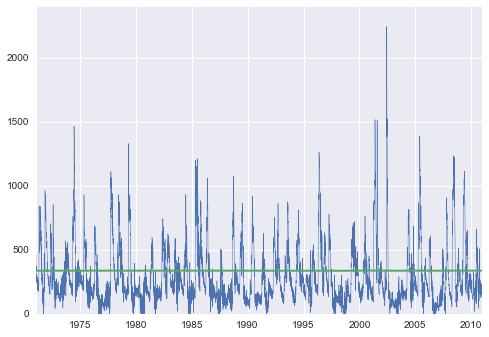

In [12]:
RLInflows = pd.read_pickle('./data/RLInflows.pkl')
df = pd.concat([RLInflows,RL['1971':'2010']],axis=1)
df.columns=['I','H']

df['I'].plot(linewidth=0.5)
plt.hold(True)
df['H'].plot(linewidth=2)
plt.hold(False)
plt.ylim(0,2400)


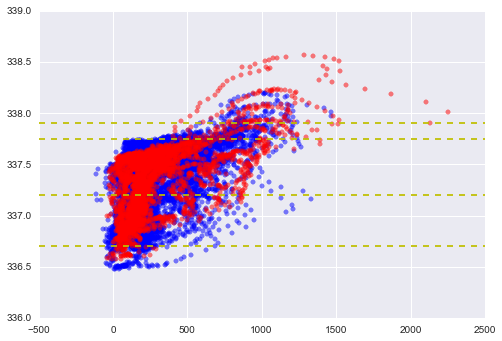

In [13]:
plt.scatter(df.ix['1971':'1999']['I'],df.ix['1971':'1999']['H'],color='b',alpha=0.5)
plt.hold(True)
plt.scatter(df.ix['2000':'2010']['I'],df.ix['2000':'2010']['H'],color='r',alpha=0.5)

ax = plt.axis()
plt.plot([ax[0],ax[1]],[337.90,337.90],'y--')
plt.plot([ax[0],ax[1]],[337.75,337.75],'y--')
plt.plot([ax[0],ax[1]],[337.20,337.20],'y--')
plt.plot([ax[0],ax[1]],[336.70,336.70],'y--')

plt.xlim(ax[0],ax[1])

plt.hold(False)

## Modeling of Rainy Lake Inflows

### Load Inflow Data

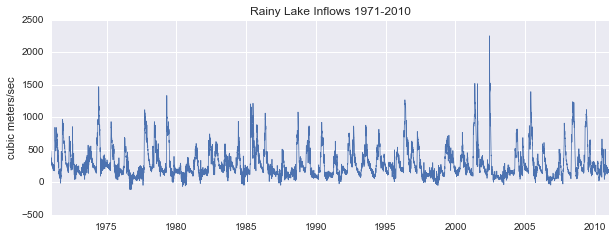

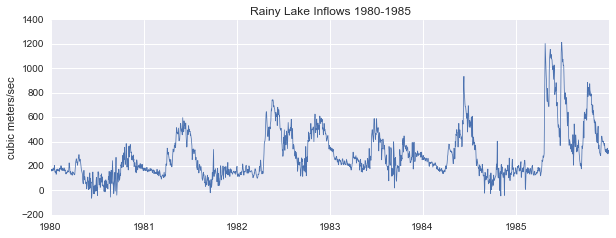

In [14]:
# Load inflow data
RLInflows = pd.read_pickle('./data/RLInflows.pkl')

def plotInflowData(Q):
    plt.figure(figsize=(10,3.5))
    Q.plot(linewidth=0.75)
    plt.title('Rainy Lake Inflows {0}-{1}'.format(
        Q.index[0].strftime('%Y'),
        Q.index[-1].strftime('%Y')))
    plt.ylabel('cubic meters/sec');
    
plotInflowData(RLInflows)
plotInflowData(RLInflows['1980':'1985'])

### Descriptive Statistics

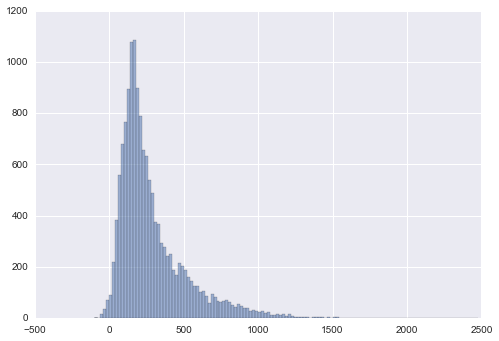

In [15]:
RLInflows.hist(bins=np.arange(-100,2500,20),alpha=0.5)


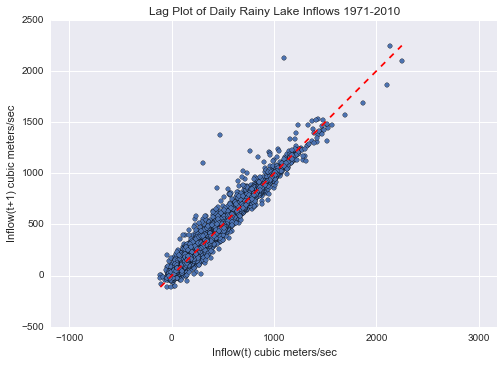

In [16]:
from pandas.tools.plotting import lag_plot

lag_plot(RLInflows,lag=1)
plt.axis('equal')
plt.hold(True)
plt.plot([RLInflows.min(),RLInflows.max()],[RLInflows.min(),RLInflows.max()],'r--')
plt.hold(False)
plt.title('Lag Plot of Daily Rainy Lake Inflows {0}-{1}'.format(
    RLInflows.index.min().strftime('%Y'),
    RLInflows.index.max().strftime('%Y')))
plt.xlabel('Inflow(t) cubic meters/sec')
plt.ylabel('Inflow(t+1) cubic meters/sec');

### Fitting a Time Series Model

The augmented Dickey-Fuller test is used to test for a unit root in a univariate process.

In [17]:
import statsmodels.api as sm
(adf, pvalue, usedlag, nobs, cvalues, icbtest) = sm.tsa.adfuller(RLInflows) 
print adf
print pvalue

-11.7600388434
1.15381832842e-21


The test statistic is strongly negative, and we can soundly reject a unit root and therefore a the non-stationary hypothesis. This was also abundantly clear from the original data.

Next we consider autocorrelations

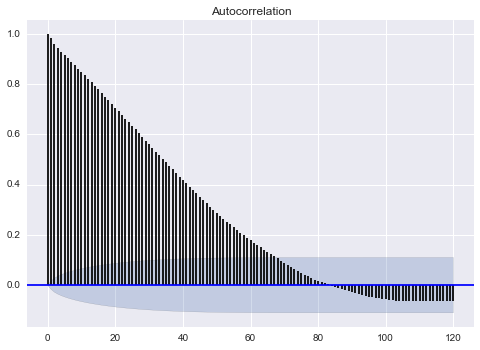

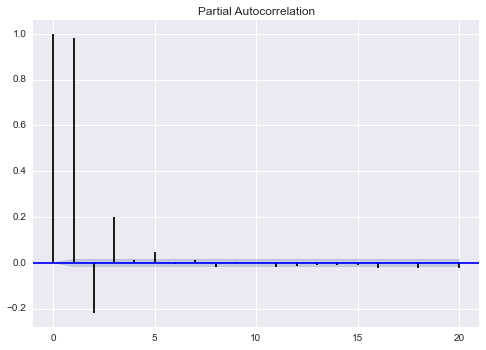

In [18]:
import statsmodels.graphics.tsaplots as tsaplots

plt.hold(True)
plt.close()
tsaplots.plot_acf(RLInflows,lags = 120);
plt.hold(False)

plt.figure()
plt.hold(True)
plt.close()
tsaplots.plot_pacf(RLInflows,lags = 20);
plt.hold(False)

In [19]:
sm.tsa.arma_order_select_ic(RLInflows.tolist(), ic=['aic', 'bic'], trend='nc')

{'aic':                0              1              2
 0            NaN  194948.116327  181328.016361
 1  149695.677261  148697.659247  148480.532504
 2  149022.025497  148564.607694  148370.097388
 3  148400.087858  148394.768405  148364.041088
 4  148398.412531  148382.398248  148356.413373,
 'aic_min_order': (4, 2),
 'bic':                0              1              2
 0            NaN  194963.295250  181350.784745
 1  149710.856184  148720.427632  148510.890350
 2  149044.793881  148594.965540  148408.044696
 3  148430.445704  148432.715713  148409.577857
 4  148436.359838  148427.935017  148409.539604,
 'bic_min_order': (2, 2)}

In [20]:
arma_mod = sm.tsa.ARMA(RLInflows.tolist(), (4,2)).fit()

print "Coeff       Value   Std. Err.    pvalue"

K = arma_mod.k_trend
k = 0
j = 0
while k < K:
    print 'tr[{0}] = {1:9.4f}     {2:7.4f}   {3:7.4f}'.format(
        j, arma_mod.params[k], arma_mod.bse[k], arma_mod.pvalues[k])
    j += 1
    k += 1
    
K += arma_mod.k_exog
j = 0
while k < K:
    print 'ex[{0}] = {1:9.4f}     {2:7.4f}   {3:7.4f}'.format(
        j, arma_mod.params[k], arma_mod.bse[k], arma_mod.pvalues[k])
    j += 1
    k += 1 
print ''

K += arma_mod.k_ar
j = 0
while k < K:
    print 'ar[{0}] = {1:9.4f}     {2:7.4f}   {3:7.4f}'.format(
        j, arma_mod.params[k], arma_mod.bse[k], arma_mod.pvalues[k])
    j += 1
    k += 1  
print ''
    
K += arma_mod.k_ma
j = 1
while k < K:
    print 'ma[{0}] = {1:9.4f}     {2:7.4f}   {3:7.4f}'.format(
        j, arma_mod.params[k], arma_mod.bse[k], arma_mod.pvalues[k])
    j += 1
    k += 1
print ''

Coeff       Value   Std. Err.    pvalue
tr[0] =  285.3931     21.4288    0.0000

ar[0] =    0.9656      0.1347    0.0000
ar[1] =    0.1292      0.1662    0.4369
ar[2] =   -0.2280      0.0740    0.0021
ar[3] =    0.1179      0.0300    0.0001

ma[1] =    0.2749      0.1344    0.0409
ma[2] =   -0.2501      0.0371    0.0000



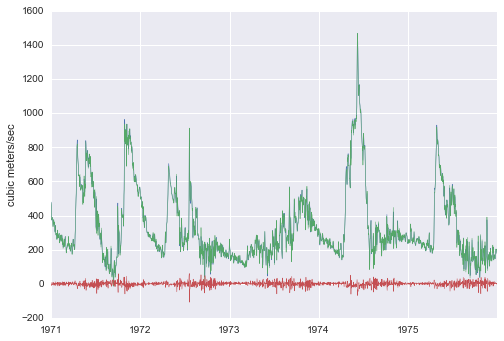

In [21]:
RLPred = pd.Series(arma_mod.predict(1,len(RLInflows),dynamic=False),
                   index=RLInflows.index)
yrA = '1971'
yrB = '1975'
RLInflows[yrA:yrB].plot(linewidth=0.5)
plt.hold(True)
RLPred[yrA:yrB].plot(linewidth=0.5)
(RLPred[yrA:yrB]-RLInflows[yrA:yrB]).plot(linewidth=0.5)
plt.ylabel('cubic meters/sec')
plt.hold(False)

## Analysis of Residuals

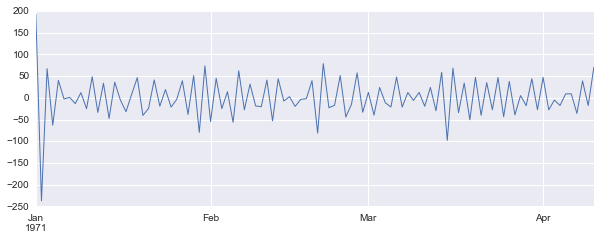

In [22]:
r = pd.Series(arma_mod.resid,index=RLInflows.index).copy()

plt.figure(figsize=(10,3.5))
r.ix[0:100].plot(linewidth=1)

import scipy.signal
    
a = np.concatenate((np.array([1]),-arma_mod.arparams))
b = np.concatenate((np.array([1]),arma_mod.maparams))

f = pd.Series(scipy.signal.lfilter(a,b,r) ,index = RLInflows.index)
f.ix[0:100].plot(linewidth=1)


plt.hold(True)

In [23]:
r.mean()

-0.0061535850319375911

In [24]:
sm.stats.durbin_watson(r)

1.9982804647252388

In [25]:
from scipy import stats
stats.normaltest(r)

(11940.331574076443, 0.0)

The very low value returned from `scipy.stats.normaltest()` tells us that the residuals are not Normally distributed.

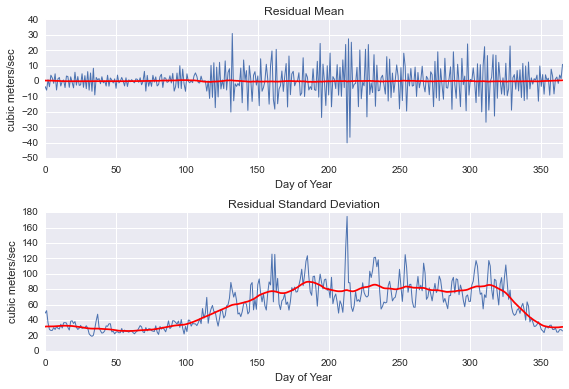

In [26]:

rmean = pd.Series([d.mean() for t,d in f.groupby(f.index.dayofyear)])
rmean_smooth = pd.rolling_window(
    pd.concat([rmean.tshift(-len(rmean),freq=1),rmean,rmean.tshift(len(rmean),freq=1)]),
    30,'triang',center=True)[rmean.index]

rstd = pd.Series([d.std() for t,d in f.groupby(f.index.dayofyear)])
rstd_smooth = pd.rolling_window(
    pd.concat([rstd.tshift(-len(rstd),freq=1),rstd,rstd.tshift(len(rstd),freq=1)]),
    30,'triang',center=True)[rstd.index]

plt.subplot(2,1,1)
plt.hold(True)
rmean.plot(linewidth=1)
rmean_smooth.plot(style='r')
plt.xlabel('Day of Year')
plt.ylabel('cubic meters/sec')
plt.title('Residual Mean')
plt.hold(False)

plt.subplot(2,1,2)
plt.hold(True)
rstd.plot(linewidth=1)
rstd_smooth.plot(style='r')
plt.xlabel('Day of Year')
plt.ylabel('cubic meters/sec')
plt.title('Residual Standard Deviation')
plt.hold(False)

plt.tight_layout()

(9312.1470634169891, 0.0)
2.83007578944 -0.0531931405403 0.362534019742


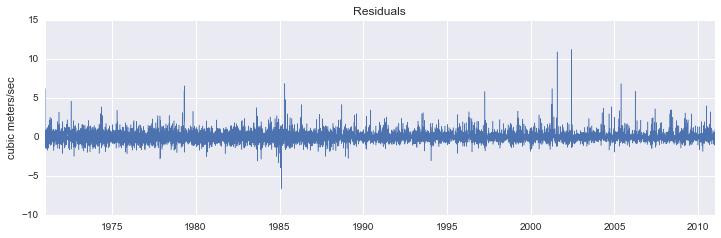

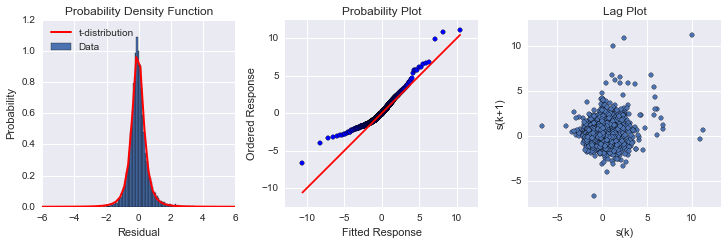

In [27]:
s = r.copy()
for k in s.index:
    s.ix[k] = (s.ix[k] - rmean_smooth.ix[k.dayofyear-1])
    s.ix[k] = s.ix[k]/rstd_smooth.ix[k.dayofyear-1]

plt.figure(figsize=(12,3.5))
s.plot(linewidth=0.5);
plt.title('Residuals')
plt.ylabel('cubic meters/sec')
print stats.normaltest(s)


from scipy import stats

df,loc,scale = stats.t.fit(s)
dist = stats.t(df,loc=loc,scale=scale)

plt.figure(figsize=(10.2,3.5))

plt.subplot(1,3,1)
s.hist(bins=200,normed=True)
plt.hold(True)
xmin,xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
plt.plot(x, dist.pdf(x), 'r', linewidth=2)
plt.xlim(-6,6)
plt.title('Probability Density Function')
plt.xlabel('Residual')
plt.ylabel('Probability')
plt.legend(['t-distribution','Data'],loc='upper left')
plt.hold(False)

print df,loc,scale

plt.subplot(1,3,2)
y = [v for v in sorted(s.tolist())]
x = [dist.ppf(float(k)/float(1+len(s))) for k in range(1,len(s)+1)]

plt.hold(True)
plt.scatter(x,y)
plt.plot([min(x),max(x)],[min(x),max(x)],'r')
plt.axis('equal')
plt.xlabel('Fitted Response')
plt.ylabel('Ordered Response')
plt.title('Probability Plot')
plt.hold(False)

plt.subplot(1,3,3)
lag_plot(s)
plt.axis('equal')
plt.title('Lag Plot')
plt.xlabel('s(k)')
plt.ylabel('s(k+1)')

plt.tight_layout()

Removing the seasonality reduced the chi-squared statistic, but it is still clearly a non-Normal distribution.

## Simulation

In [28]:
#e = pd.Series(dist.rvs(len(s)), index = s.index)
e = pd.Series(0, index = s.index)
plt.figure(figsize=(12,7))

for k in e.index:
    e.ix[k] = random.choice(s)
    
plt.subplot(2,1,1)
e.plot(linewidth=0.5)

for k in e.index:
    e.ix[k] = e.ix[k]*rstd_smooth.ix[k.dayofyear-1]
    #e.ix[k] = random.choice(s)*rstd_smooth.ix[k.dayofyear-1]
    e.ix[k] += rmean_smooth.ix[k.dayofyear-1]

plt.subplot(2,1,2)
e.plot(linewidth=0.5)

import scipy.signal
    
a = np.concatenate((np.array([1]),-arma_mod.arparams))
b = np.concatenate((np.array([1]),arma_mod.maparams))

f = pd.Series(scipy.signal.lfilter(b,a,e) + arma_mod.params[0],index = e.index)

plotInflowData(f)
f['1971':'1975'].plot(linewidth=0.5)
plt.hold(True)
#RLInflows['1981':'1981'].plot()
#(f-RLInflows['1981':'1981']).plot()
#e.plot(linewidth=0.5)
plt.hold(False)
print f.mean()

NameError: name 'random' is not defined

In [ ]:
plotInflowData(f)

In [ ]:
#N = 5001
#e = pd.Series(dist.rvs(N), index = pd.date_range(pd.datetime.today().date(), periods=N))
#e = s['1981':'1981'].copy()
#for k in e.index:
#    e.ix[k] = e.ix[k]*rstd_smooth.ix[k.dayofyear-1]
#    e.ix[k] += rmean_smooth.ix[k.dayofyear-1]

import scipy.signal
    
a = np.concatenate((np.array([1]),-arma_mod.arparams))
b = np.concatenate((np.array([1]),arma_mod.maparams))

f = pd.Series(scipy.signal.lfilter(b,a,e) + arma_mod.params[0],index = e.index)
f['1971':'1975'].plot(linewidth=0.5)
plt.hold(True)
#RLInflows['1981':'1981'].plot()
#(f-RLInflows['1981':'1981']).plot()
#e.plot(linewidth=0.5)
plt.hold(False)
print f.mean()

In [ ]:
import scipy.signal
    
a = np.concatenate((np.array([1]),-arma_mod.arparams))
b = np.concatenate((np.array([1]),arma_mod.maparams))

y = RLInflows.tolist()
e = scipy.signal.lfilter(a,b,y)
e = pd.Series(e,index=RLInflows.index)
e['1986'].plot(linewidth=0.5)
plt.hold(True)
tsaplots.plot_acf(e,lags = 100);
plt.hold(False)

e = e - e.mean()
ep = e.ix[e >= 0]
en = -e.ix[e <= 0]
en.plot()

en.hist(bins=range(0,300),normed=True,color='g',alpha=0.5)
plt.hold(True)
ep.hist(bins=range(0,300),color='r',alpha=0.5,normed=True)
plt.hold(False)
plt.xlim(0,200)

In [ ]:
from pandas.tools.plotting import lag_plot
lag_plot(RLInflows['1971':'1999'].diff(),color='b',alpha=0.4)
plt.hold(True)
lag_plot(RLInflows['2000':'2010'].diff(),color='r',alpha=0.4)
plt.hold(False)
plt.axis('equal')

In [ ]:
RLInflows['1971':'1999'].diff().hist(bins=np.arange(-400,1200,20),color='b',alpha=0.5,normed=True)
plt.hold(True)
RLInflows['2000':'2011'].diff().hist(bins=np.arange(-400,1200,20),color='r',alpha=0.5,normed=True)
plt.hold(False)

## <a name=section04></a>Correlation of Precipitation with Lake Inflow

In [ ]:
x['I'].plot()

In [ ]:
KINL = pd.read_pickle(dir+'KINL.pkl')

plt.hold(True)
(10*KINL[yrA:yrB]).plot()
x['I'].plot()
plt.hold(False)
